In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def plot_image_frame(image_frame):
    for ii,image in enumerate(image_frame):
        plt.figure()
        if isinstance(image,list):
            image=image[0]
        plt.imshow(image)
        plt.title('frame: '+str(ii))
        plt.show()
def plot_trajectories(pose_frame):
    pose_frame=np.array(pose_frame)
    timestep,joint_num,dim=pose_frame.shape
    joints=['neck','shoulder','elbow','hand']
    plt.figure(figsize=(12,7))
    t=np.arange(timestep)
    for ii,mark in enumerate(joints):
        plt.subplot(331)
        plt.plot(t,pose_frame[:,ii,0],label=mark)
        plt.xlabel('t'); plt.ylabel('x')
        plt.subplot(332)
        plt.plot(t,pose_frame[:,ii,1],label=mark)
        plt.xlabel('t'); plt.ylabel('y')
        if dim>2:
            plt.subplot(333)
            plt.plot(t,pose_frame[:,ii,2],label=mark)
            plt.xlabel('t'); plt.ylabel('z')
    plt.subplots_adjust(wspace =0.5, hspace =0)
    plt.legend(loc=(1,0.4))
    plt.show()
def plot_trajectory_3d(ser):
    xs = ser[:,0]
    ys = ser[:,1]
    zs = ser[:,2]
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot3D(xs, ys, zs=zs, marker='o', color='b')
    plt.show()

# Kinect - Openpose Pipline for Trajectory Prediction

## 1. read data

original depth image frames


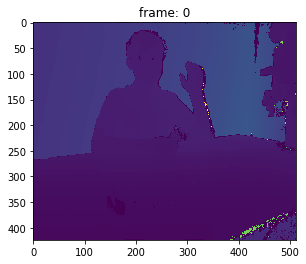

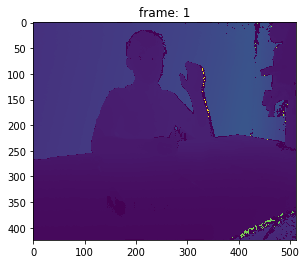

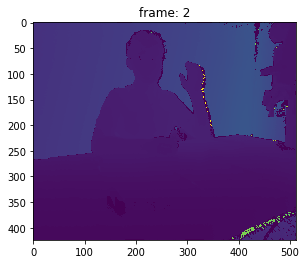

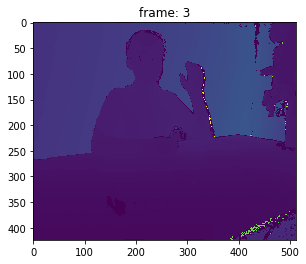

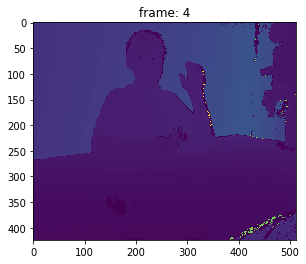

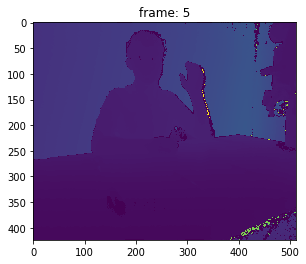

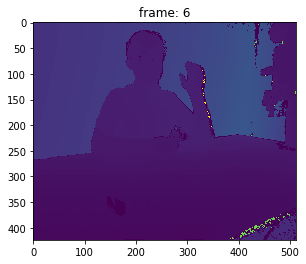

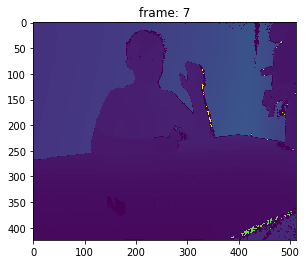

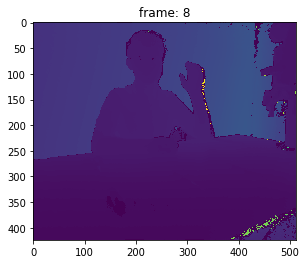

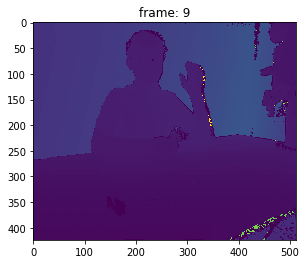

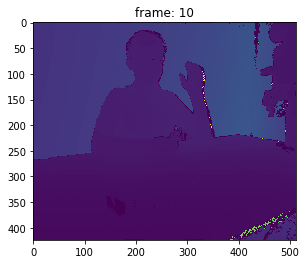

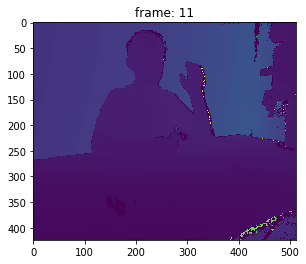

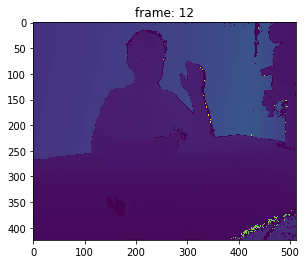

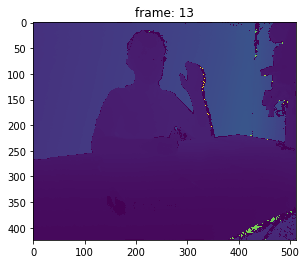

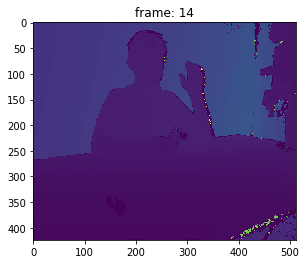

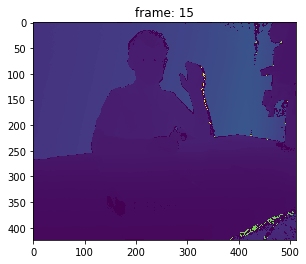

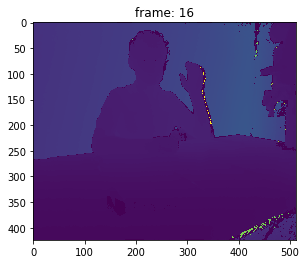

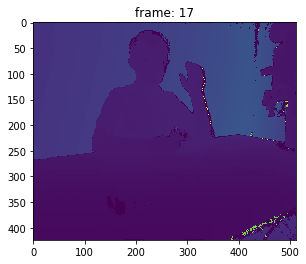

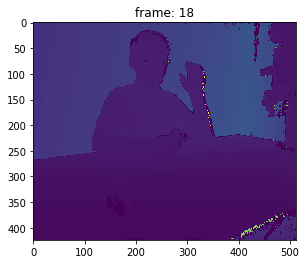

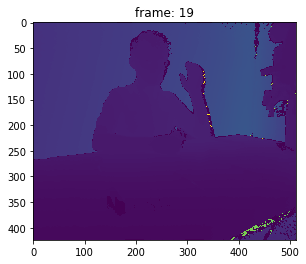

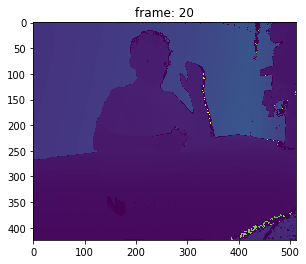

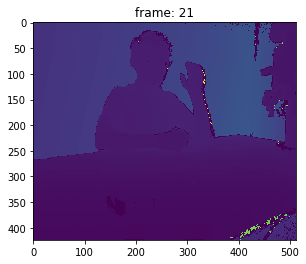

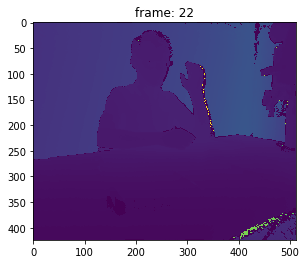

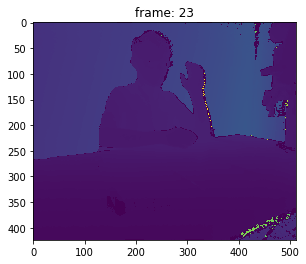

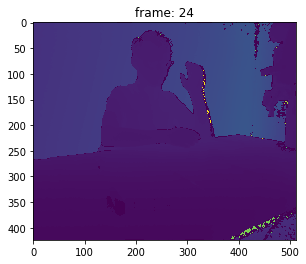

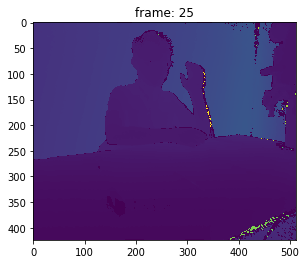

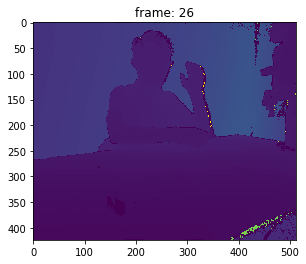

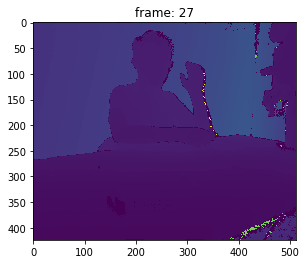

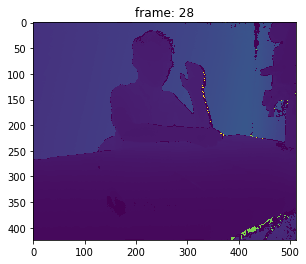

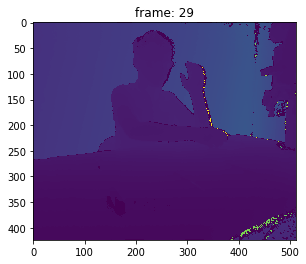

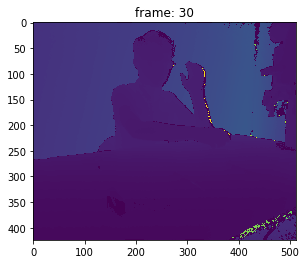

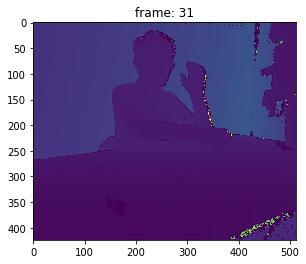

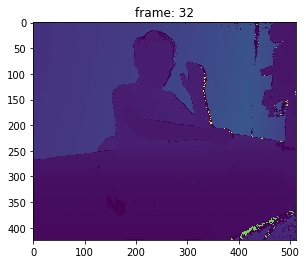

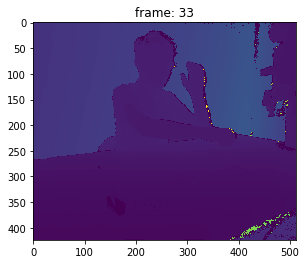

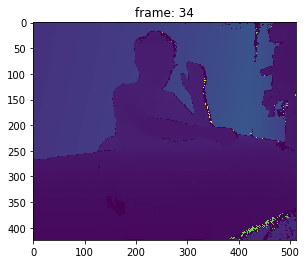

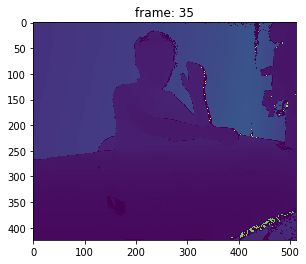

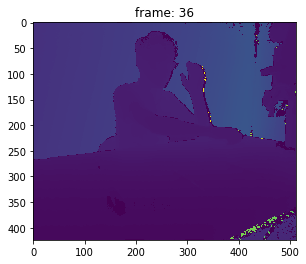

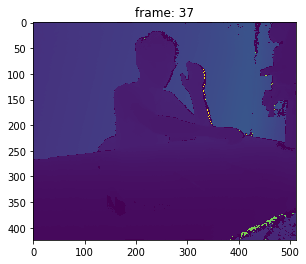

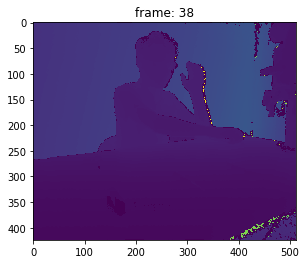

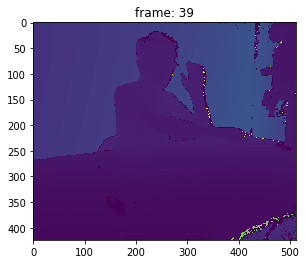

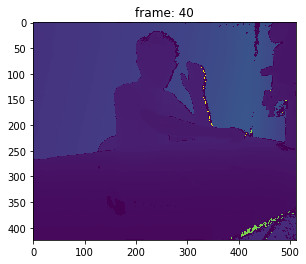

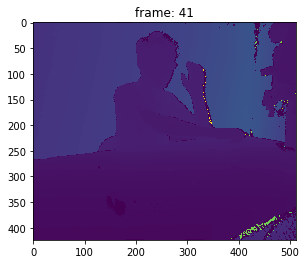

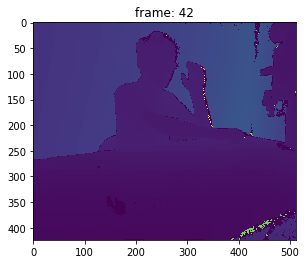

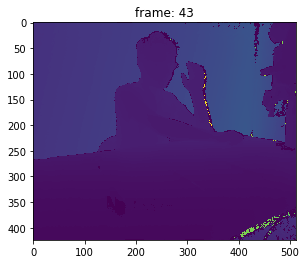

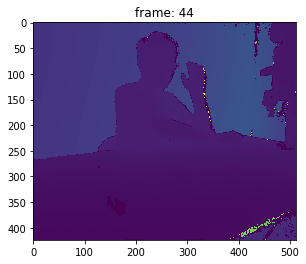

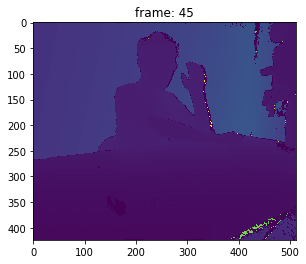

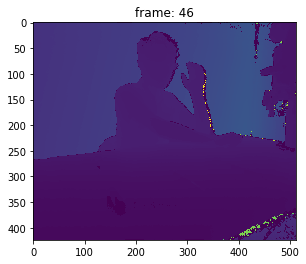

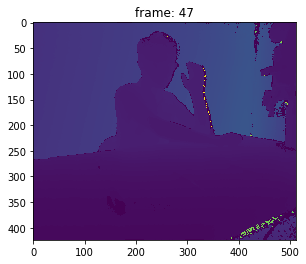

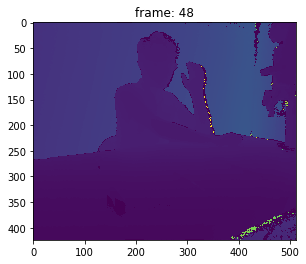

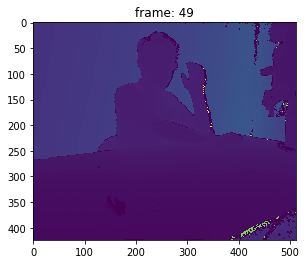

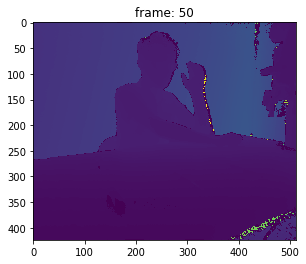

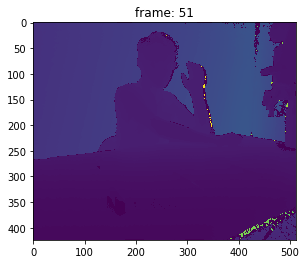

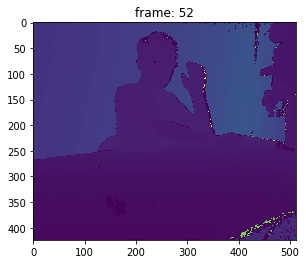

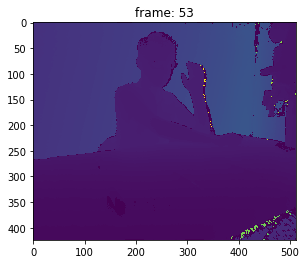

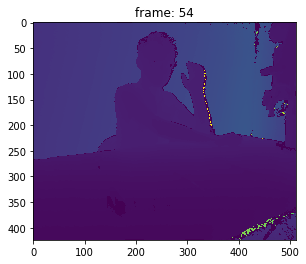

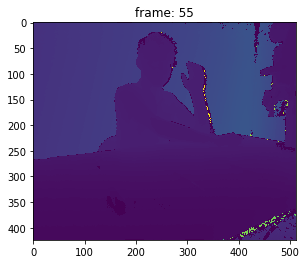

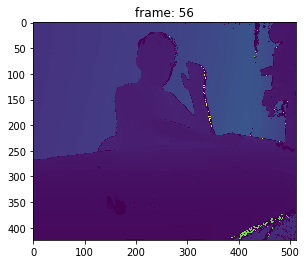

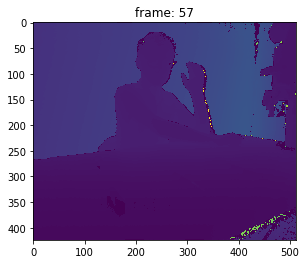

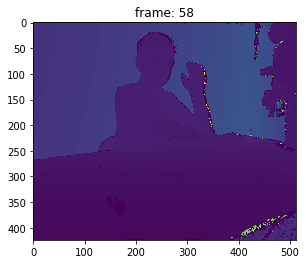

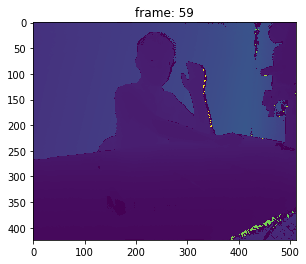

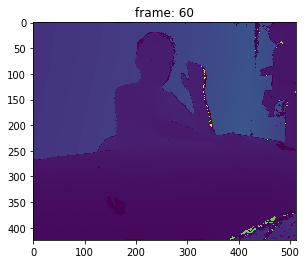

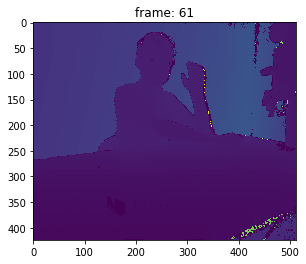

In [4]:
image_path='data/img_0_1562348459.p'
image_frame = pickle.load(open(image_path, 'rb'), encoding='iso-8859-1')
print('original depth image frames')
plot_image_frame(image_frame)

openpose trajectories


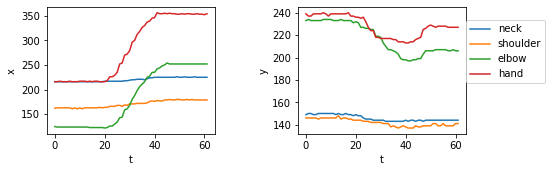

In [5]:
pose_path='data/0_1562348459.p'
pose_frame = pickle.load(open(pose_path, 'rb'), encoding='iso-8859-1')
print('openpose trajectories')
plot_trajectories(pose_frame)

## 2. smooth depth image

In [6]:
from kinect_smoothing import HoleFilling_Filter, Denoising_Filter

hole filled image frames (filled invalid values)


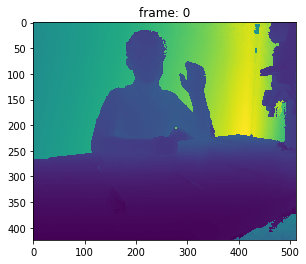

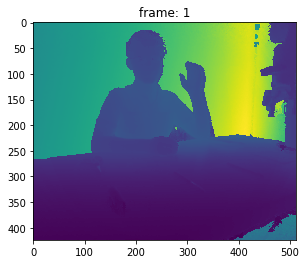

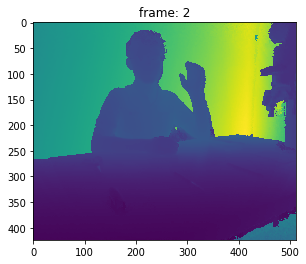

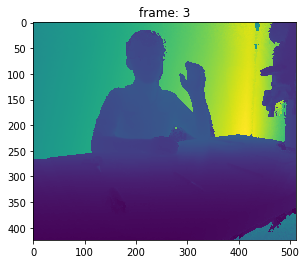

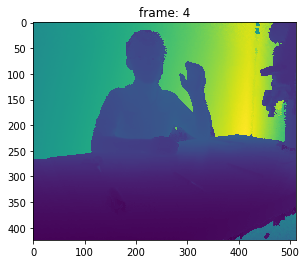

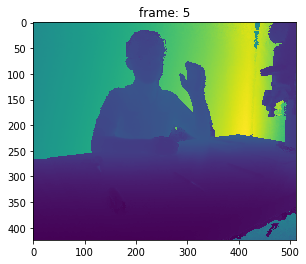

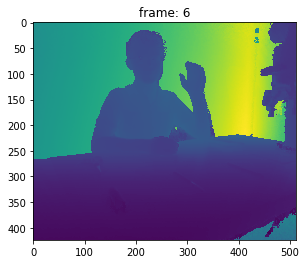

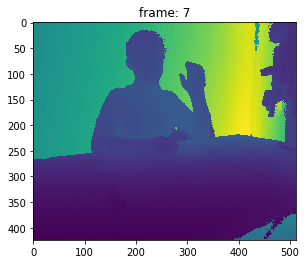

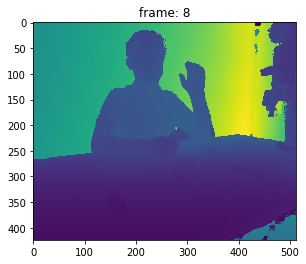

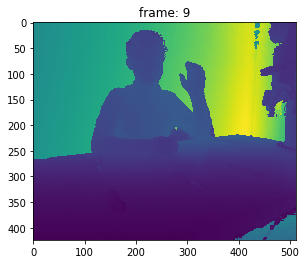

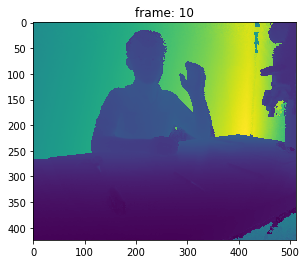

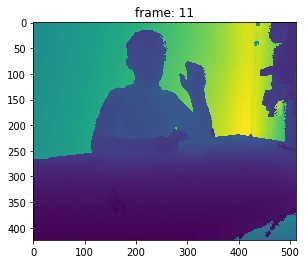

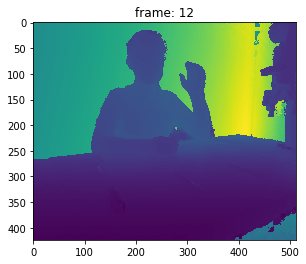

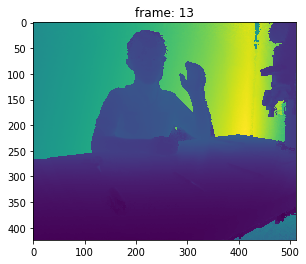

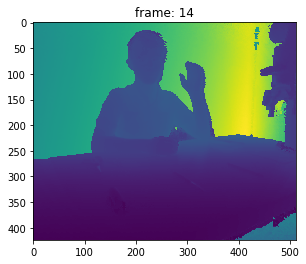

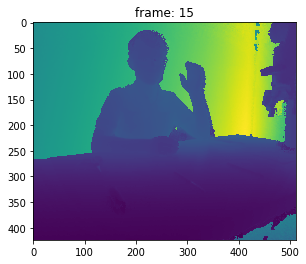

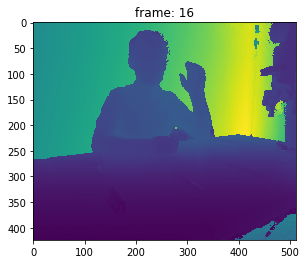

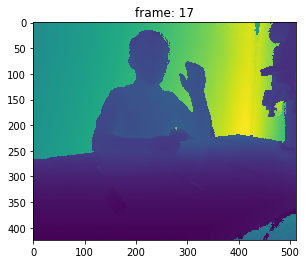

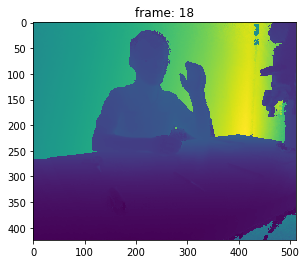

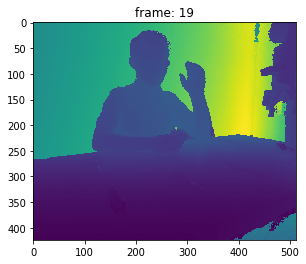

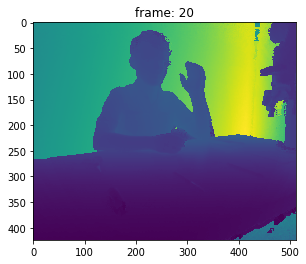

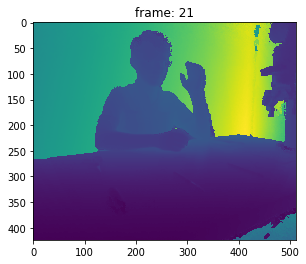

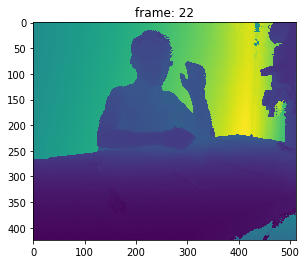

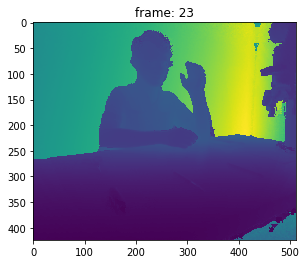

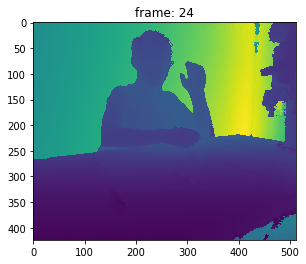

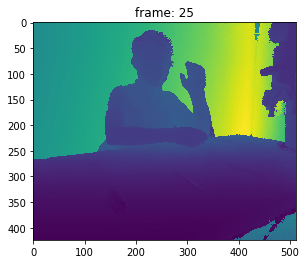

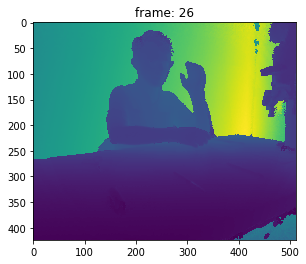

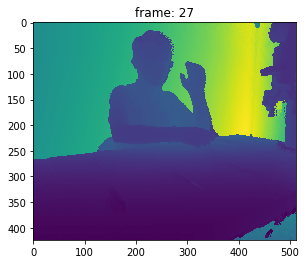

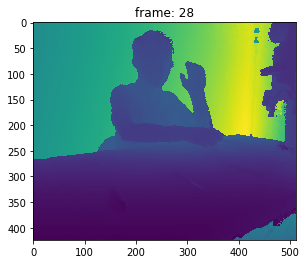

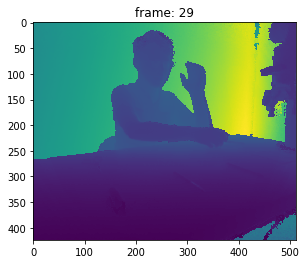

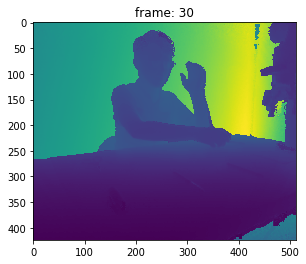

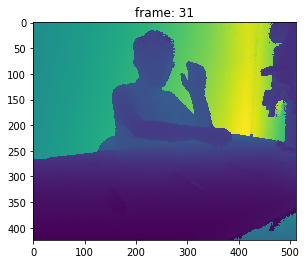

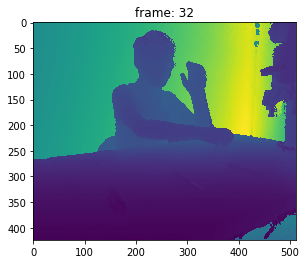

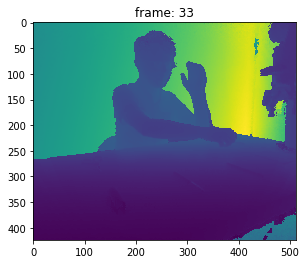

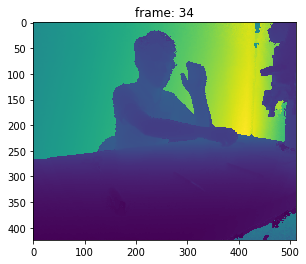

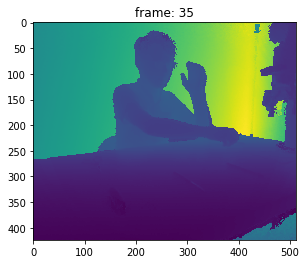

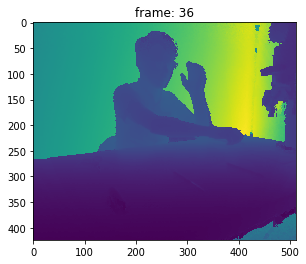

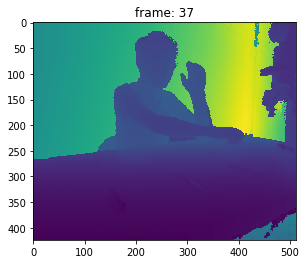

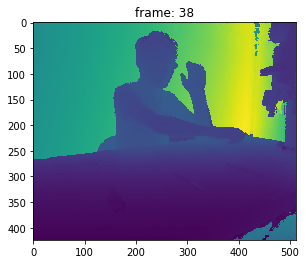

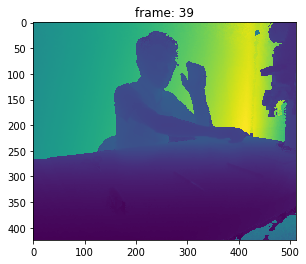

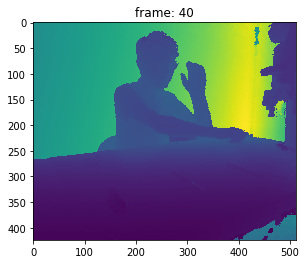

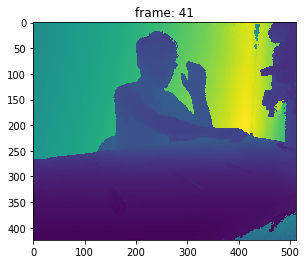

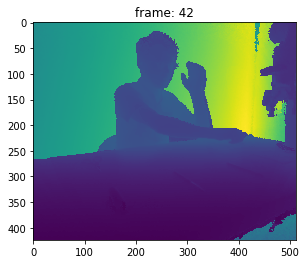

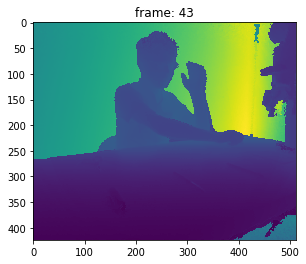

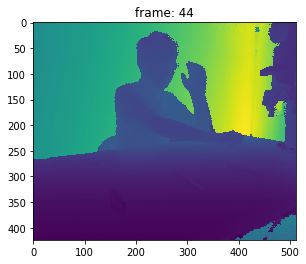

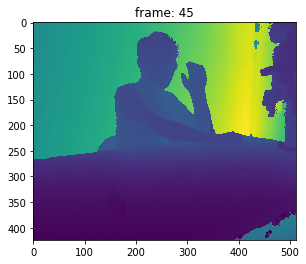

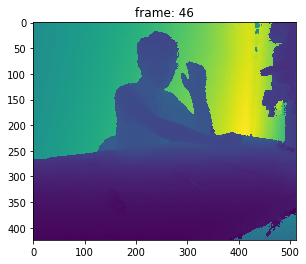

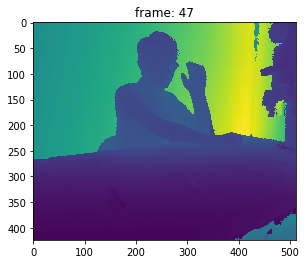

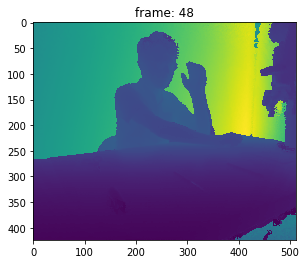

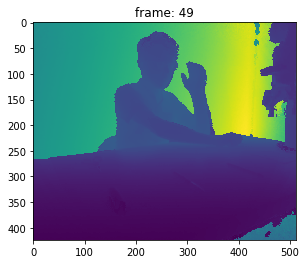

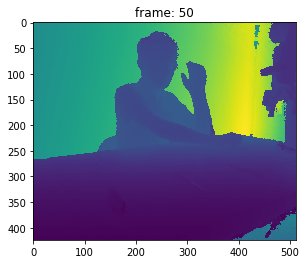

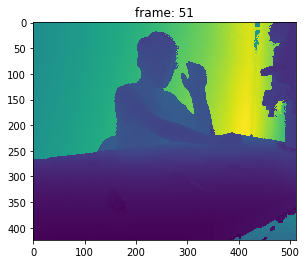

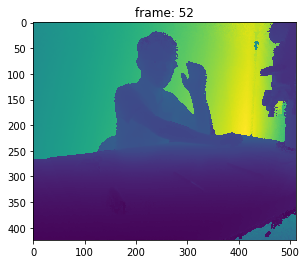

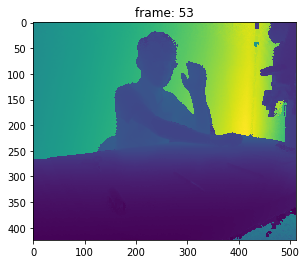

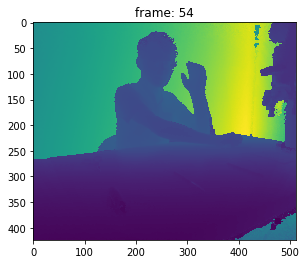

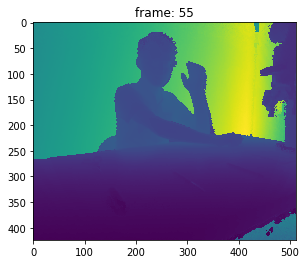

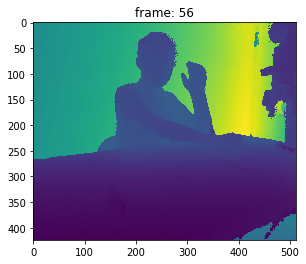

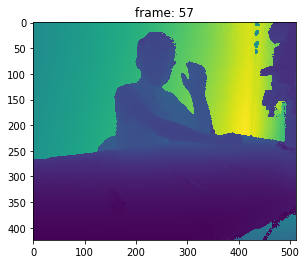

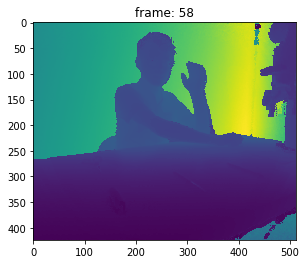

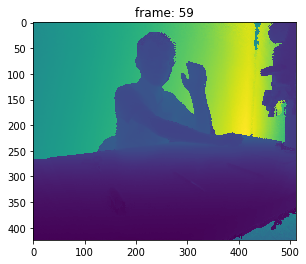

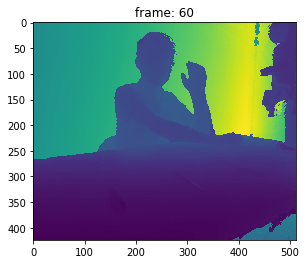

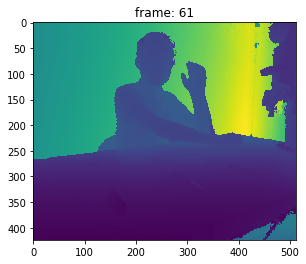

In [7]:
hole_filter = HoleFilling_Filter(flag='min')
hf_image_frame = hole_filter.smooth_image_frames(image_frame)
print('hole filled image frames (filled invalid values)')
plot_image_frame(hf_image_frame)

denoised image frames (optional)


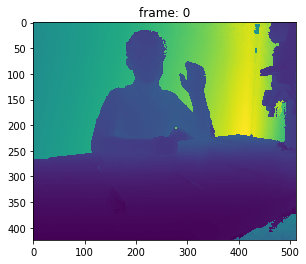

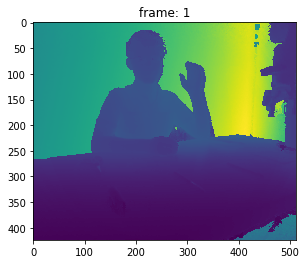

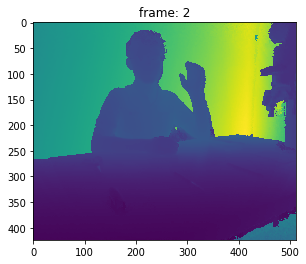

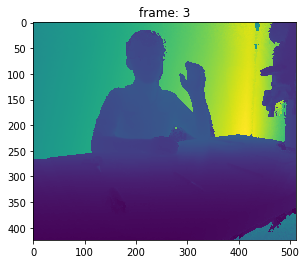

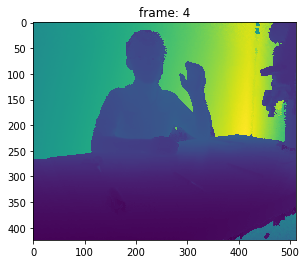

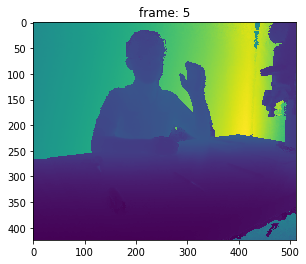

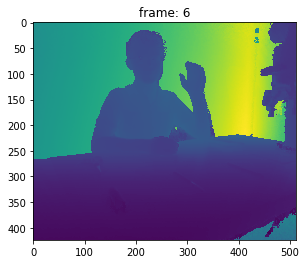

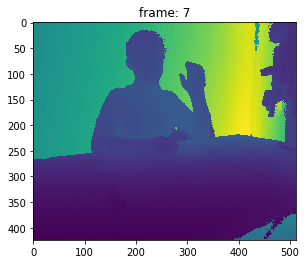

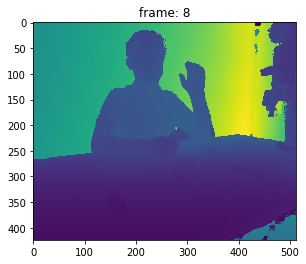

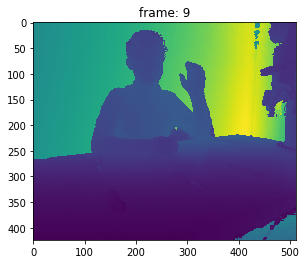

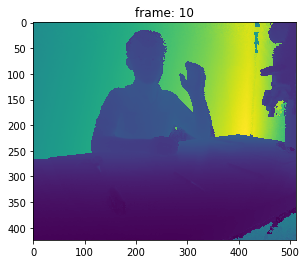

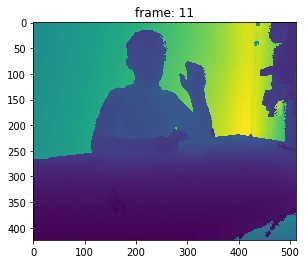

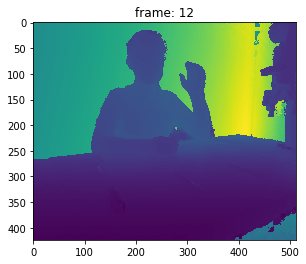

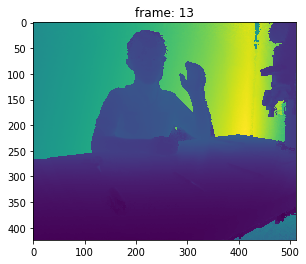

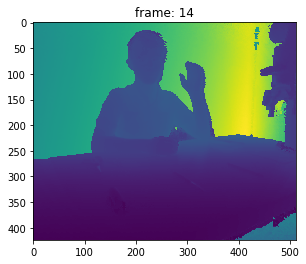

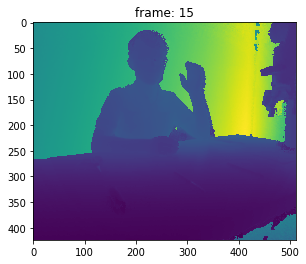

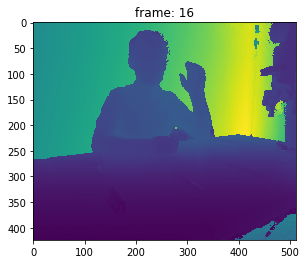

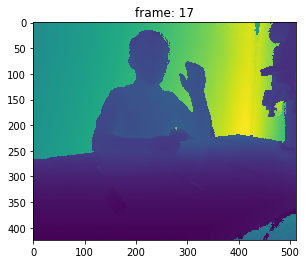

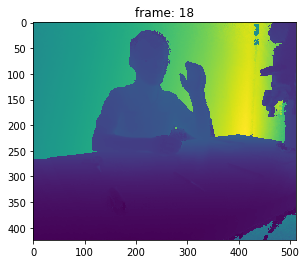

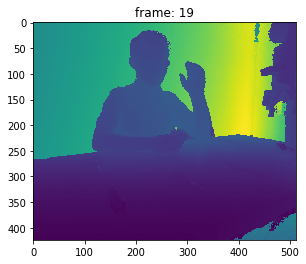

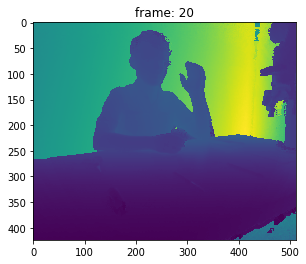

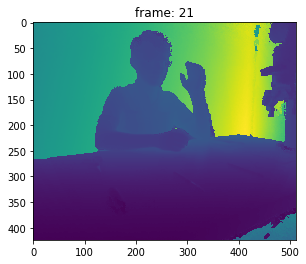

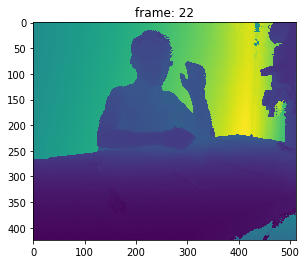

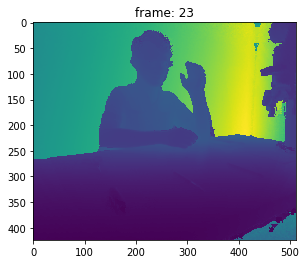

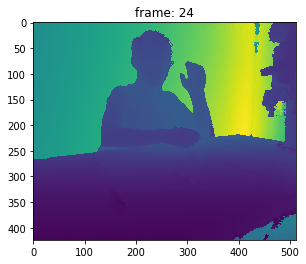

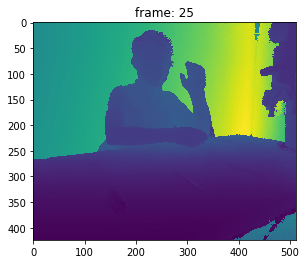

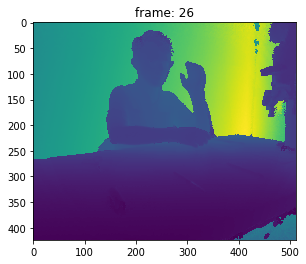

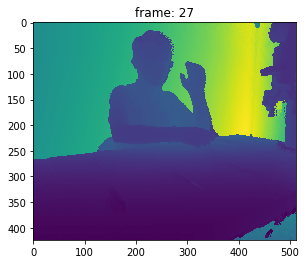

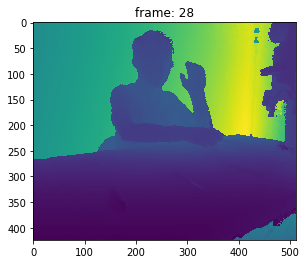

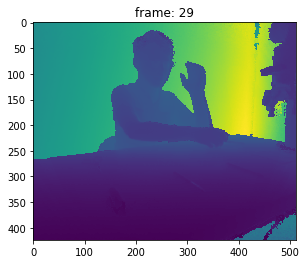

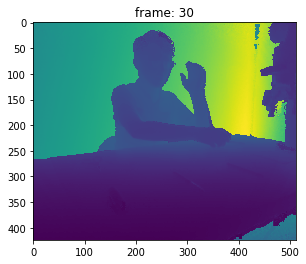

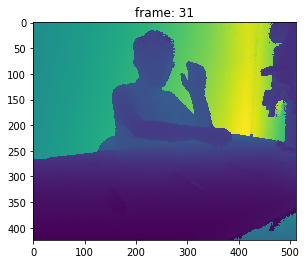

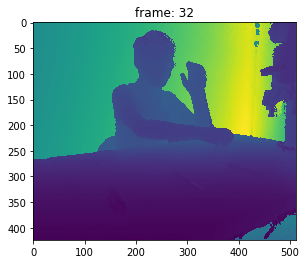

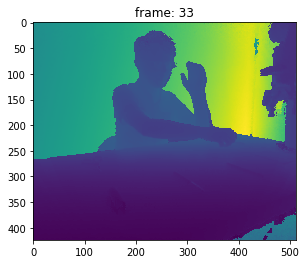

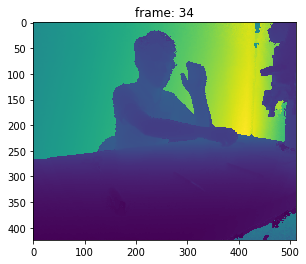

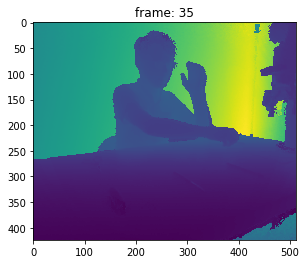

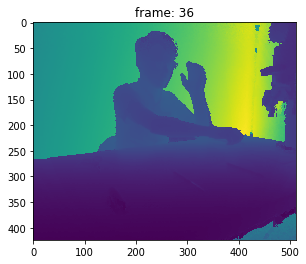

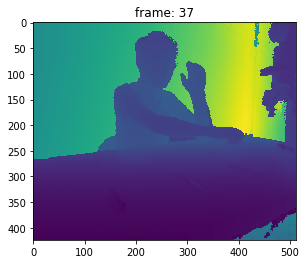

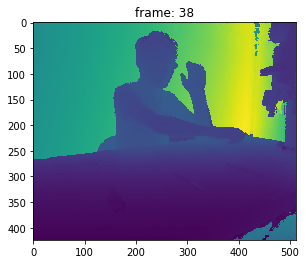

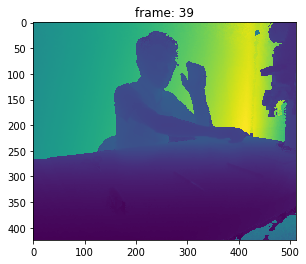

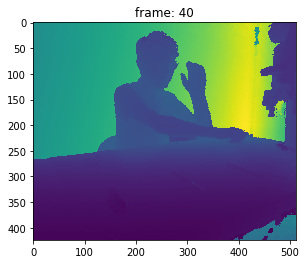

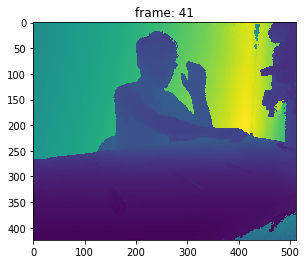

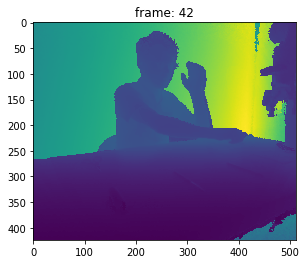

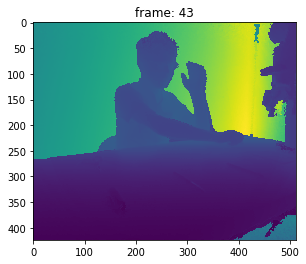

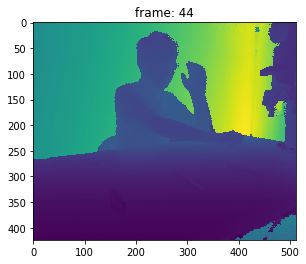

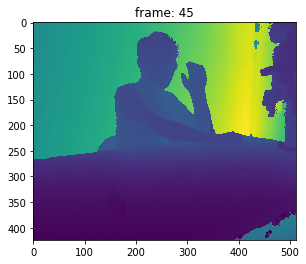

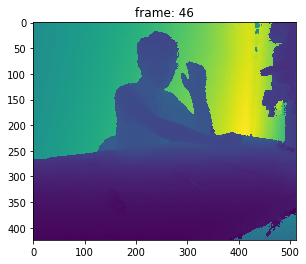

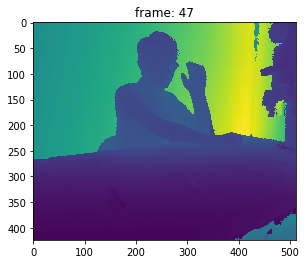

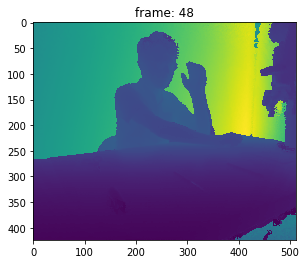

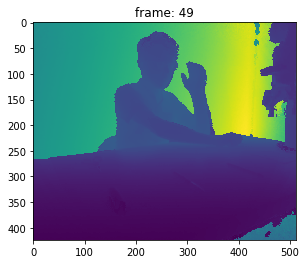

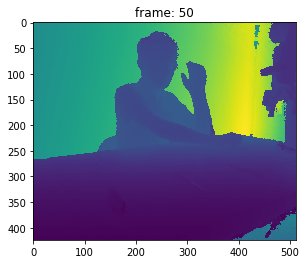

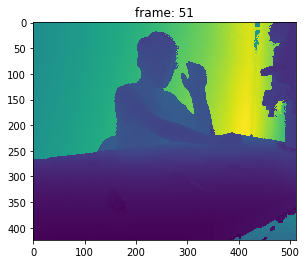

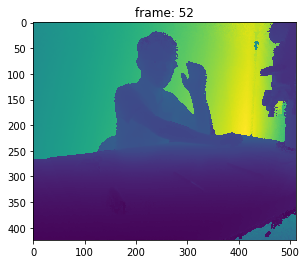

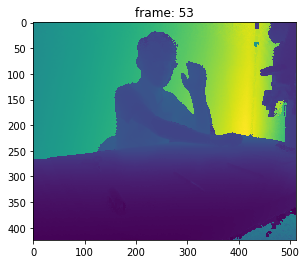

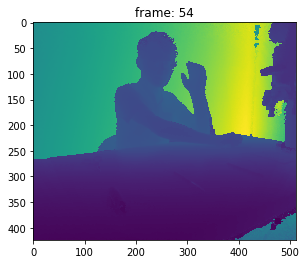

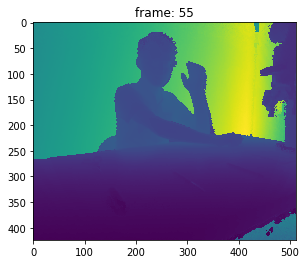

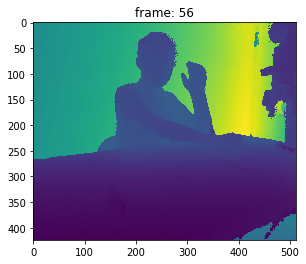

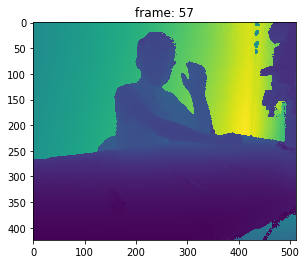

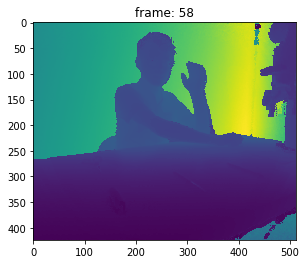

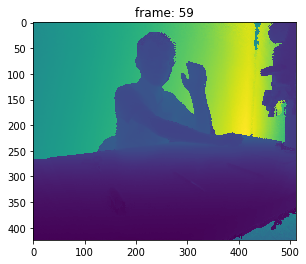

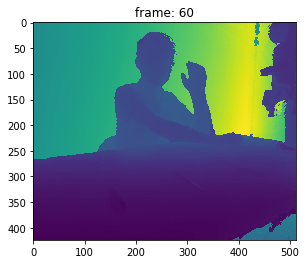

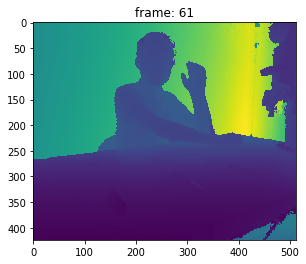

In [8]:
noise_filter = Denoising_Filter(flag='anisotropic', theta=60) 
denoise_image_frame = noise_filter.smooth_image_frames(hf_image_frame)
print('denoised image frames (optional)')
plot_image_frame(denoise_image_frame)

## 3.  get the depth coordinate

In [9]:
from kinect_smoothing import Crop_Filter
from kinect_smoothing import Coordinate_Calculator

In [15]:
pose_frame.shape

(62, 4, 2)

raw trajectories


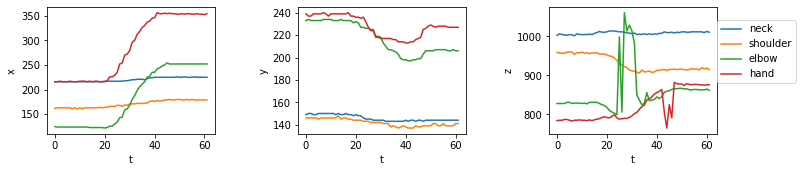

In [16]:
pose_filter = Crop_Filter(flag='pchip')
cropped_pose_frame = pose_filter.smooth_multi_trajectories(pose_frame)
calcutator = Coordinate_Calculator()
raw_pose = calcutator.get_depth_coordinate(denoise_image_frame, cropped_pose_frame)
print('raw trajectories')
plot_trajectories(raw_pose)

## 4. smooth the trajectory and convert to real coordinate

In [18]:
from kinect_smoothing import Kalman_Filter

smoothed raw trajectories


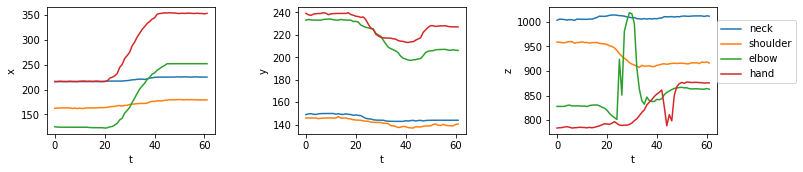

In [19]:
smoothed_raw_pose = pose_filter.smooth_multi_trajectories(raw_pose)
smooth_filter = Kalman_Filter()
smoothed_raw_pose = smooth_filter.smooth_multi_trajectories(smoothed_raw_pose)
print('smoothed raw trajectories')
plot_trajectories(smoothed_raw_pose)

real word trajectories


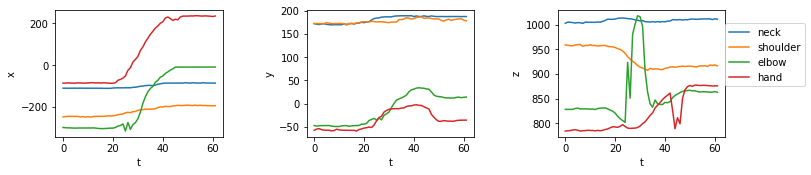

In [21]:
real_pose = calcutator.convert_real_coordinate(smoothed_raw_pose)
print('real word trajectories')
plot_trajectories(real_pose)

hand trjectory 3d


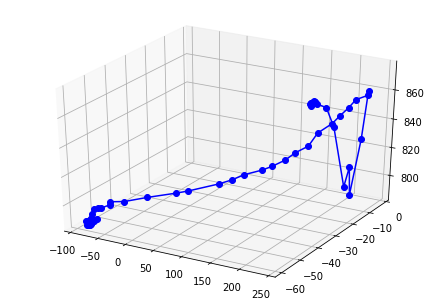

In [22]:
print('hand trjectory 3d')
plot_trajectory_3d(real_pose[:,-1,])

## 5. motion detection (optional)

In [23]:
from kinect_smoothing import Motion_Sampler

real word trajectories (stillness point has been deleted)


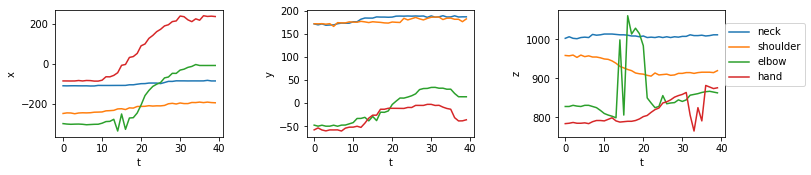

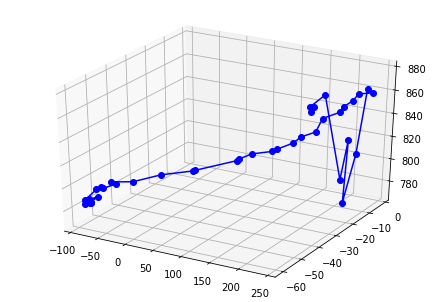

In [33]:
motion_filter = Motion_Sampler(motion_threshold=20, min_time_step=30)
sampled_real_pose =   motion_filter.motion_detection(real_pose)
print('real word trajectories (stillness point has been deleted)')
plot_trajectories(sampled_real_pose)
plot_trajectory_3d(sampled_real_pose[:,-1,])

## Simple pipline

In [31]:
from kinect_smoothing import Kinect_Openpose_Pipeline

real word trajectories


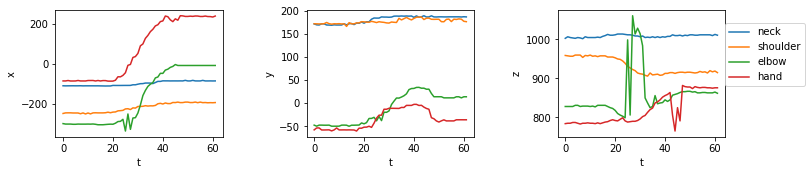

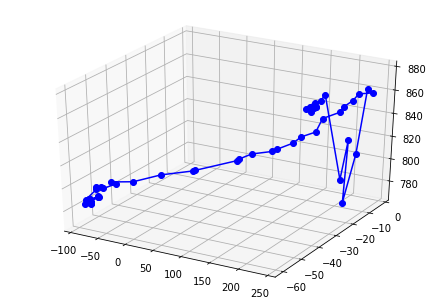

In [32]:
pipeline = Kinect_Openpose_Pipeline()
real_pose = pipeline(image_frame,pose_frame)
print('real word trajectories')
plot_trajectories(real_pose)
plot_trajectory_3d(real_pose[:,-1,])